## Hani example

Simple steady state model using a regular MODFLOW grid to simulate the
response of an anisotropic confined aquifer to a pumping well. A
constant-head boundary condition surrounds the active domain.  K22 is set
to 0.01.  Drawdown is more pronounced in the K11 direction.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.cvfdutil
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-hanir": {"angle1": 0, "xt3d": False},
    "ex-gwf-hanix": {"angle1": 25, "xt3d": True},
    "ex-gwf-hanic": {"angle1": 90, "xt3d": False},
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 51  # Number of rows
ncol = 51  # Number of columns
delr = 10.0  # Spacing along rows ($m$)
delc = 10.0  # Spacing along columns ($m$)
top = 0.0  # Top of the model ($m$)
botm = -10.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Horizontal hydraulic conductivity in the 11 direction ($m/d$)
k22 = 0.01  # Horizontal hydraulic conductivity in the 22 direction ($m/d$)
pumping_rate = -1.0  # Pumping rate ($m^3/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)

perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, angle1, xt3d):
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        k22=k22,
        angle1=angle1,
        save_specific_discharge=True,
        xt3doptions=xt3d,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    ibd = -1 * np.ones((nrow, ncol), dtype=int)
    ibd[1:-1, 1:-1] = 1
    chdrow, chdcol = np.where(ibd == -1)
    chd_spd = [[0, i, j, 0.0] for i, j in zip(chdrow, chdcol)]
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD",
    )
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=[0, 25, 25, pumping_rate],
        pname="WEL",
    )
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Set default figure properties
figure_size = (3.5, 3.5)


def plot_grid(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="CHD")
        pmv.plot_bc(name="WEL")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_head(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        head = gwf.output.head().get_data()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        cb = pmv.plot_array(0 - head, cmap="jet", alpha=0.25)
        cs = pmv.contour_array(0 - head, levels=np.arange(0.1, 1, 0.1))
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Drawdown, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-head.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    if idx == 0:
        plot_grid(idx, sim)
    plot_head(idx, sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 44.74 ms


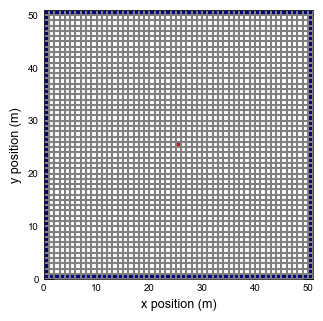

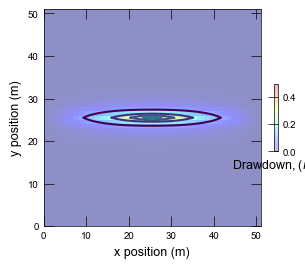

run_models took 62.31 ms


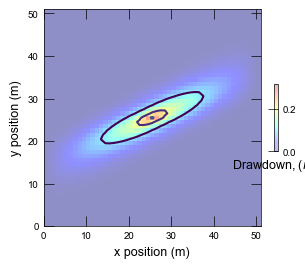

run_models took 45.65 ms


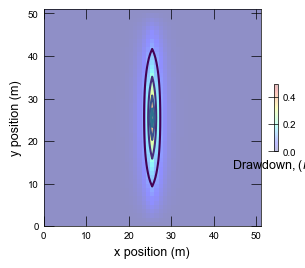

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)


# Run the Hani model with anisotropy in x direction and plot heads.

scenario(0)

# Run the Hani model with anisotropy in y direction and plot heads.

scenario(1)

# Run the Hani model with anisotropy rotated 15 degrees and plot heads.

scenario(2)